In [1]:
import abtem
import matplotlib.pyplot as plt
from ase.build import graphene
from ase.io import write

(examples:stem_quickstart)=
# STEM quickstart

This notebook demonstrates a basic simulation of a scanning transmission electron microscopy image of graphene with a silicon dopant.

## Configuration

We start by (optionally) setting our configuration. See [documentation](reference:configuration) for details.

In [2]:
abtem.config.set(
    {
        "device": "cpu",
        "fft": "fftw",
        "diagnostics.task_progress": True,
        "diagnostics.progress_bar": "tqdm",
    }
)

## Atomic model
We create an orthogonal graphene cell. See our [walkthough](walkthrough:atomic_models) or our [tutorial](tutorials:advanced_atomic_models) on atomic models. 

In [3]:
atoms = abtem.orthogonalize_cell(graphene(vacuum=2))

atoms = atoms * (5, 3, 1)

We dope the graphene with silicon by changing the atomic number of one of the atoms.

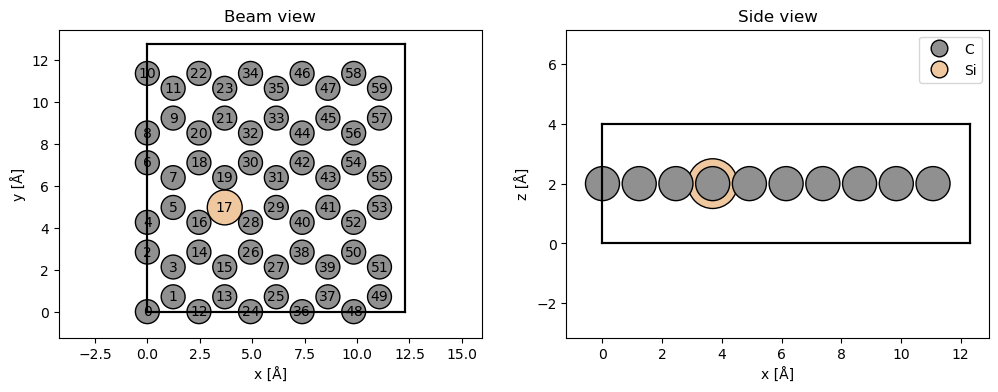

In [4]:
atoms.numbers[17] = 14

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
abtem.show_atoms(atoms, ax=ax1, title="Beam view", numbering=True, merge=False)
abtem.show_atoms(atoms, ax=ax2, plane="xz", title="Side view", legend=True);

## Potential

We create an ensemble of potentials using the frozen phonon model. See our [walkthrough on frozen phonons](walkthrough:frozen_phonons). 

In [5]:
frozen_phonons = abtem.FrozenPhonons(atoms, 8, sigmas=0.1)

We create a potential from the frozen phonons model, see [walkthrough on potentials](walkthrough:potentials).

In [6]:
potential = abtem.Potential(frozen_phonons, sampling=0.05)

## Wave function

We create a probe wave function at an energy of $80 \ \mathrm{keV}$, an objective aperture of $30 \ \mathrm{mrad}$, a spherical aberration of $10 \ \mu\mathrm{m}$ and Scherzer defocus. See our [walkthrough on wave functions](walkthrough:wave_functions).

Partial temporal coherence is neglected here, see our [tutorial on partial coherence](tutorials:partial_coherence). 

In [7]:
probe = abtem.Probe(energy=80e3, semiangle_cutoff=25, Cs=10e4, defocus="scherzer")
probe.grid.match(potential)

print(f"defocus = {probe.aberrations.defocus} Å")
print(f"FWHM = {probe.profiles().width().compute()} Å")

defocus = 79.14274499114904 Å
FWHM = 0.8963562846183777 Å


We show the profile of the probe.

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

tasks:   0%|          | 0/2 [00:00<?, ?it/s]

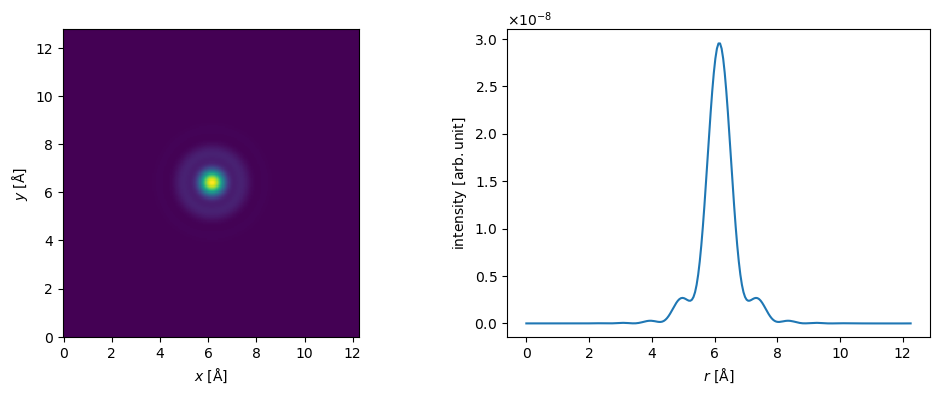

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
probe.show(ax=ax1)
probe.profiles().show(ax=ax2);

## Scan

We select a scan region using fractional coordinates. We scan at the Nyquist frequency, allowing us to interpolate the measurements below.

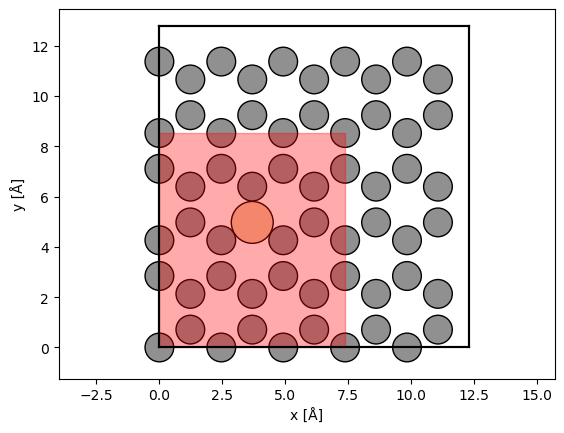

In [9]:
grid_scan = abtem.GridScan(
    start=(0, 0),
    end=(3 / 5, 2 / 3),
    sampling=probe.aperture.nyquist_sampling,
    fractional=True,
    potential=potential,
)

fig, ax = abtem.show_atoms(atoms)

grid_scan.add_to_plot(ax)

## Scan and detect

We use a flexible annular detector, this will let us choose the detector angles after the running multislice.

In [10]:
detector = abtem.FlexibleAnnularDetector()

We run the scanned multislice algorithm. See our [walkthrough on scanning and detecting](walkthrough:scan_and_detect).

In [11]:
flexible_measurement = probe.scan(potential, scan=grid_scan, detectors=detector)

flexible_measurement.compute()

tasks:   0%|          | 0/108 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

multislice:   0%|          | 0/48 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/120 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

multislice:   0%|          | 0/960 [00:00<?, ?it/s]

multislice:   0%|          | 0/384 [00:00<?, ?it/s]

## Integrate measurements

The measurements are integrated to obtain the bright field, medium-angle annular dark field and high-angle annular dark field signals.

In [12]:
bf_measurement = flexible_measurement.integrate_radial(0, probe.semiangle_cutoff)
maadf_measurement = flexible_measurement.integrate_radial(50, 150)
haadf_measurement = flexible_measurement.integrate_radial(90, 200)

The measurements are stacked and shown as an exploded plot.

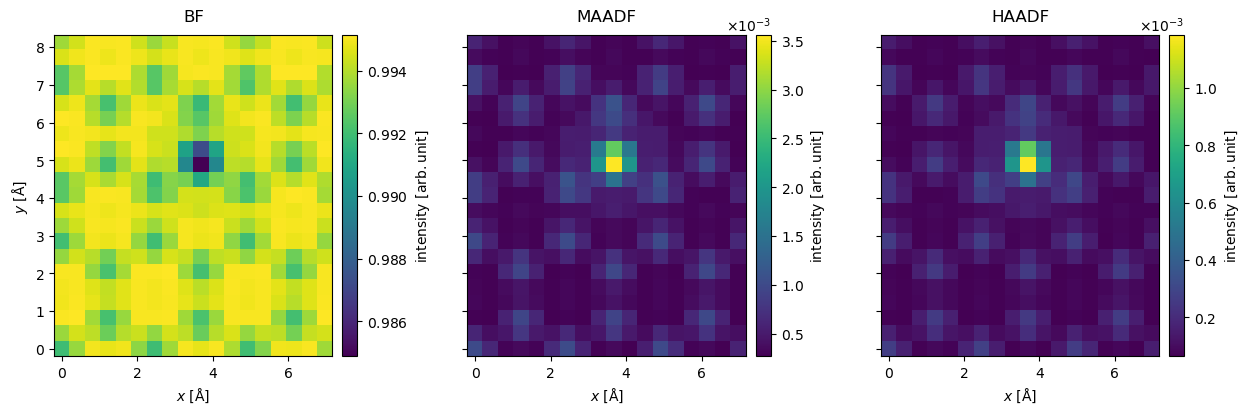

In [13]:
measurements = abtem.stack(
    [bf_measurement, maadf_measurement, haadf_measurement], ("BF", "MAADF", "HAADF")
)

measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

## Postprocessing

Typically some post-processing steps are necessary to obtain the final results, see our [walkthrough on scanning and detecting](walkthrough:scan_and_detect) for more details

The measurements are interpolated to a sampling rate of $0.05 \ \mathrm{Å / pixel}$.

In [14]:
interpolated_measurements = measurements.interpolate(0.05)

We can simulate partial spatial coherence by applying a gaussian filter. The standard deviation of the filter is $0.3 \ \mathrm{Å}$, the approximate size of the electron source.

In [15]:
filtered_measurements = interpolated_measurements.gaussian_filter(0.3)

The interpolated and filtered measurements shown as an exploded plot.

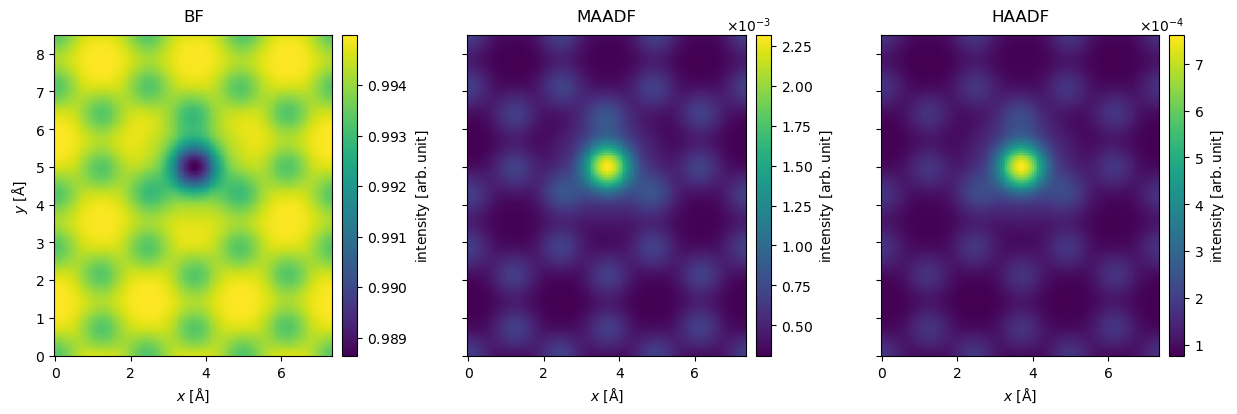

In [16]:
filtered_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

We simulate a finite electron dose of $10^7 \ \mathrm{e}^- / \mathrm{Å}^2$ by applying poisson noise

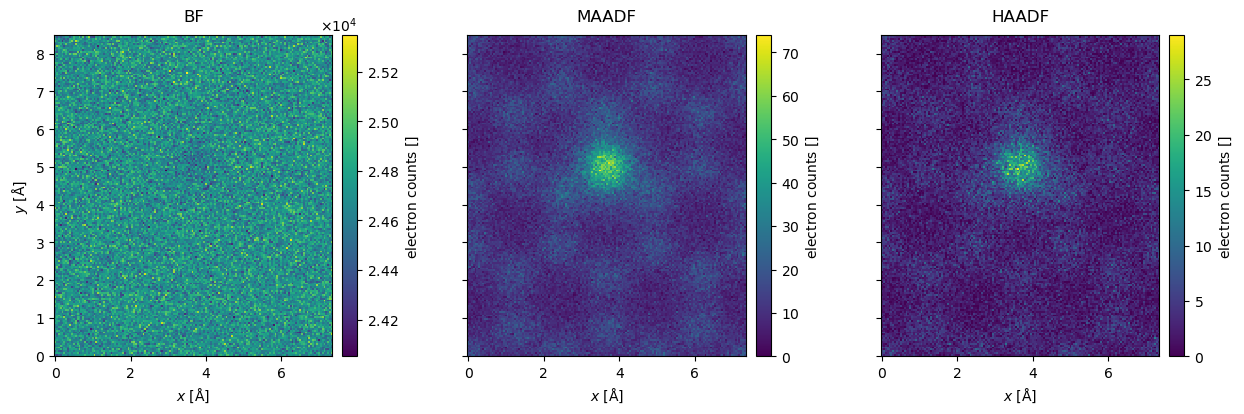

In [17]:
noisy_measurements = filtered_measurements.poisson_noise(dose_per_area=1e7)

noisy_measurements.show(
    explode=True,
    figsize=(14, 5),
    cbar=True,
);

Showing the results as a line profile often provides a better sense of relative intensities. 

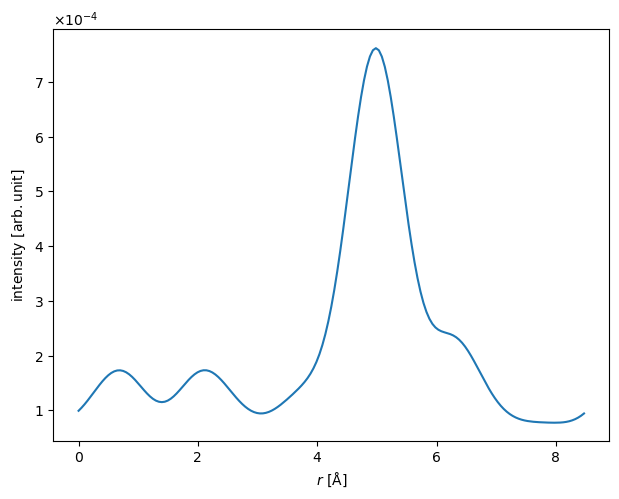

In [18]:
line_profile = filtered_measurements.interpolate_line(
    start=(1 / 2, 0), end=(1 / 2, 1), fractional=True
)

line_profile[-1].show();

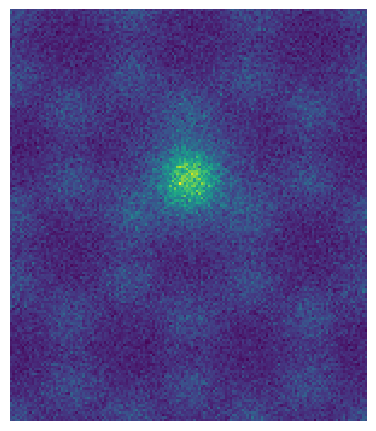

In [19]:
visualization = noisy_measurements[1].show()
visualization.axis_off()
plt.savefig("../thumbnails/stem_quickstart.png", bbox_inches="tight", pad_inches=0)